<div style="color:#8a2be2;margin:0;font-size:60px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;overflow:hidden;font-weight:600;">Smoke Detection <br>Single-Shot Detector (SSD)</div>

<h2 style="text-align: left; font-family: Arial; font-size: 20px; font-color: black;font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color:#000000; background-color: #ffffff;">CREATED BY: Pavankumar Elango</h2>

<br>    
<p style="text-align: center;">
<img src="https://media.istockphoto.com/id/956591688/photo/fighting-fire-with-fire.jpg?s=612x612&w=0&k=20&c=2uRmH_nVuGqsht7UJ54HKTWb8gDq4IbXdY6Ylt3BncE=" style='width: 800px; height: 500px;'>
</p>

<h2 style="text-align: left; font-family: Arial; font-size: 25px; font-color: black;font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color:#8a2be2; background-color: #ffffff;">Smoke Detection Algorithm </h2>


<h2 style="text-align: left; font-family: Arial; font-size: 18px; font-color: black;font-style: normal; text-decoration: None; text-transform: none; letter-spacing: 1px; color:#000000; background-color: #ffffff;">Smoke detection is essential in defining the  early  detection  of  a  fire.  Smoke  can  be determined by the characteristics of its five main parts.  First,  we  convert  input  video  into  a sequence  of  frames  and  determine  objects  of moving  areas  in  an  image  by  subtracting  the frames to find all objects  in  each  frame. Motion detection  is  also used, In  addition to converting the image  to  HSV color, we  also  use models  to analyze color and intensity smoke candidate features. Furthermore, we remove or reduce undesirable lightness pixels and track the objects that  meet the threshold and conditions.  The  standard  deviation  was calculated  for  each  color  component  (RGB)  of The colors of the  resulting  object. We adopt the highest  values  and  compare  them  with  the characteristics  of  smoke  to  determine  whether smoke is present. Finally, Fourier transform was used to  calculate the  transparency of  all  objects during  the  smoke,  thereby  the  accuracy  of  the system increases. </h2>


<h2 style="text-align: left; font-family: Arial; font-size: 25px; font-color: black;font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color:#8a2be2; background-color: #ffffff;">🧑‍🔧 1.Installing  the libraries</h2>


<h2 style="text-align: left; font-family: Arial; font-size: 20px; font-color: black;font-style: normal; text-decoration: None; text-transform: none; letter-spacing: 1px; color:#000000; background-color: #ffffff;">
PYCOCO TOOLS : Python library that provides tools and utilities for working with the COCO (Common Objects in Context) dataset. The COCO dataset is a large-scale object detection, segmentation, and captioning dataset commonly used for benchmarking computer vision algorithms.<br/>
FFMPEG:powerful open-source software suite for handling multimedia data, including audio, video, and other types of streams. It provides a command-line interface to perform various operations on multimedia files, such as converting between different formats, encoding and decoding, transcoding, streaming, and more. FFmpeg supports a wide range of codecs, formats, and protocols, making it a versatile tool for multimedia processing and manipulation.</h2>

In [1]:
!pip install pycocotools
! pip install -U ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 2.1 MB/s eta 0:00:0000:0100:01m
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6080 sha256=cde9db351df0753ba18b1ffa5d054eea6c02eb32311aed0a837621c35c754762
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


<h2 style="text-align: left; font-family: Arial; font-size: 25px; font-color: black;font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color:#8a2be2; background-color: #ffffff;">🛠️2.Importing  the libraries</h2>


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import cv2
from PIL import Image
import seaborn as sns
import copy
import torch
from torch.utils.data import Dataset,DataLoader,Subset
import torch.optim as optim
import torchvision
from torchvision.models.detection.ssd import SSDHead,det_utils
from torchvision.models.detection import ssd300_vgg16,SSD300_VGG16_Weights
import torchvision.transforms.functional as tf
import albumentations as A
import pycocotools
import torchmetrics
from torchmetrics.detection import MeanAveragePrecision


<h2 style="text-align: left; font-family: Arial; font-size: 25px; font-color: black;font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color:#8a2be2; background-color: #ffffff;">⛓️3.Initializing the path</h2>


In [3]:
np.random.seed(42)
torch.manual_seed(42)
img_dir="/kaggle/input/smoke-pascal-voc/images"
annot_dir="/kaggle/input/smoke-pascal-voc/annotations"


<h2 style="text-align: left; font-family: Arial; font-size: 25px; font-color: black;font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color:#8a2be2; background-color: #ffffff;">⚙️📏4.Configurtion Parameters</h2>

In [4]:
#label 0 is fixed for background
classes=["background","smoke"]

num_classes=2
device="cuda" if torch.cuda.is_available() else "cpu"
batch_size=4
epochs=40
learning_rate=3e-5

model_weights_file="model.pth"

threshold=0.25
iou_threshold=0.75


<h2 style="text-align: left; font-family: Arial; font-size: 25px; font-color: black;font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color:#8a2be2; background-color: #ffffff;">▶• ıl. 04.XML to CSV Conversion</h2>

In [5]:
def parse_xml(annot_path):
    tree=ET.parse(annot_path)
    root=tree.getroot()
    
    width=int(root.find("size").find("width").text)
    height=int(root.find("size").find("height").text)
    boxes=[]
    
    for obj in root.findall("object"):
        bbox=obj.find("bndbox")
        xmin=int(bbox.find("xmin").text)
        ymin=int(bbox.find("ymin").text)
        xmax=int(bbox.find("xmax").text)
        ymax=int(bbox.find("ymax").text)
        
        boxes.append([xmin,ymin,xmax,ymax])
        
    return boxes,height,width

In [6]:
ignore_img=[]
for annot_name in os.listdir(annot_dir):
    img_name=annot_name[:-4]+".jpg"
    annot_path=os.path.join(annot_dir,annot_name)
    boxes,height,width=parse_xml(annot_path)
    
    for box in boxes:
        if box[0]<0 or box[0]>=box[2] or box[2]>width:
            print(box[0],box[2],width)
            print("x",annot_name)
            print("*"*50)
            ignore_img.append(img_name)
        elif box[1]<0 or box[1]>=box[3] or box[3]>height:
            print(box[1],box[3],height)
            print("y",file_name)
            print("*"*50)
            ignore_img.append(img_name)


<h2 style="text-align: left; font-family: Arial; font-size: 25px; font-color: black;font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color:#8a2be2; background-color: #ffffff;">📚📻5.Data Augumentation</h2>


<h2 style="text-align: left; font-family: Arial; font-size: 20px; font-color: black;font-style: normal; text-decoration: None; text-transform: none; letter-spacing: 1px; color:#000000; background-color: #ffffff;">
defines data transformations using the Albumentations library for both training and validation datasets in an object detection pipeline..<br/>
These transformations are essential for data augmentation during training (train_transform) and ensuring consistency during validation (val_transform). They help improve the model's generalization ability, robustness, and performance by generating diverse training samples and ensuring that input images are consistently processed during both training and validation stages.






</h2>




In [7]:
train_transform=A.Compose([A.HorizontalFlip(),
                           A.ShiftScaleRotate(rotate_limit=15,value=0,
                                              border_mode=cv2.BORDER_CONSTANT),

                           A.OneOf(
                                   [A.CLAHE(),
                                    A.RandomBrightnessContrast(),
                                    A.HueSaturationValue()],p=1),
                           A.GaussNoise(),
                           A.RandomResizedCrop(height=480,width=480)],
                          bbox_params=A.BboxParams(format="pascal_voc",min_visibility=0.15,
                                                   label_fields=["labels"]))
                           
val_transform=A.Compose([A.Resize(height=480,width=480)],
                        bbox_params=A.BboxParams(format="pascal_voc",min_visibility=0.15,
                                                 label_fields=["labels"]))

<h2 style="text-align: left; font-family: Arial; font-size: 25px; font-color: black;font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color:#8a2be2; background-color: #ffffff;">✨📚 6.Custom Object Detection</h2>
<h2 style="text-align: left; font-family: Arial; font-size: 20px; font-color: black;font-style: normal; text-decoration: None; text-transform: none; letter-spacing: 1px; color:#000000; background-color: #ffffff;">
This class encapsulates the functionality required to load images, parse annotations, apply transformations, and return data in a format suitable for training or evaluation of object detection models in PyTorch.</h2>

In [8]:
class SmokeDetection(Dataset):
    def __init__(self,img_dir,annot_dir,transform=None):
        super().__init__()
        self.img_dir=img_dir
        self.annot_dir=annot_dir
        self.img_list=sorted([img for img in os.listdir(self.img_dir) 
                              if img not in ignore_img])
        self.transform=transform
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self,idx):
        img_name=self.img_list[idx]
        img_path=os.path.join(self.img_dir,img_name)
        img=cv2.imread(img_path)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        
        annot_name=img_name[:-4]+".xml"
        annot_path=os.path.join(self.annot_dir,annot_name)
        boxes,height,width=parse_xml(annot_path)
        labels=[1]*len(boxes)
        
        if self.transform is not None:
            transformed=self.transform(image=img,bboxes=boxes,labels=labels)
            img=transformed["image"]
            boxes=transformed["bboxes"]
            labels=transformed["labels"]
        
        if len(np.array(boxes).shape)!=2 or np.array(boxes).shape[-1]!=4:
            boxes=[[0.0,0.0,1.0,1.0]]
            labels=[0]
                
        img=img/255
        img=tf.to_tensor(img)
        img=img.to(dtype=torch.float32)
        target={}
        target["boxes"]=torch.tensor(boxes,dtype=torch.float32)
        target["labels"]=torch.tensor(labels,dtype=torch.int64)
        target["id"]=torch.tensor(idx)
            
        return img,target

In [9]:
train_ds=SmokeDetection(img_dir,annot_dir,train_transform)
val_ds=SmokeDetection(img_dir,annot_dir,val_transform)

<h2 style="text-align: left; font-family: Arial; font-size: 25px; font-color: black;font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color:#8a2be2; background-color: #ffffff;">🧮7.Splitting the dataset</h2>

In [10]:
from torch.utils.data import Subset
idxs=list(range(len(train_ds)))

np.random.shuffle(idxs)
train_idx=idxs[:int(0.85*len(train_ds))]
val_idx=idxs[int(0.85*len(train_ds)):]

train_ds=Subset(train_ds,train_idx)
val_ds=Subset(val_ds,val_idx)

<h2 style="text-align: left; font-family: Arial; font-size: 25px; font-color: black;font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color:#8a2be2; background-color: #ffffff;">📸8.Data Visualization</h2>

In [11]:
def show_bbox(img,target,color=(0,255,0)):
    img=np.transpose(img.cpu().numpy(),(1,2,0))
    boxes=target["boxes"].cpu().numpy().astype("int")
    labels=target["labels"].cpu().numpy()
    img=img.copy()
    for i,box in enumerate(boxes):
        idx=int(labels[i])
        text=classes[idx]

        cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),color,2)
        y=box[1]-10 if box[1]-10>10 else box[1]+10
        cv2.putText(img,text,(box[0],y),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)
        
    return img

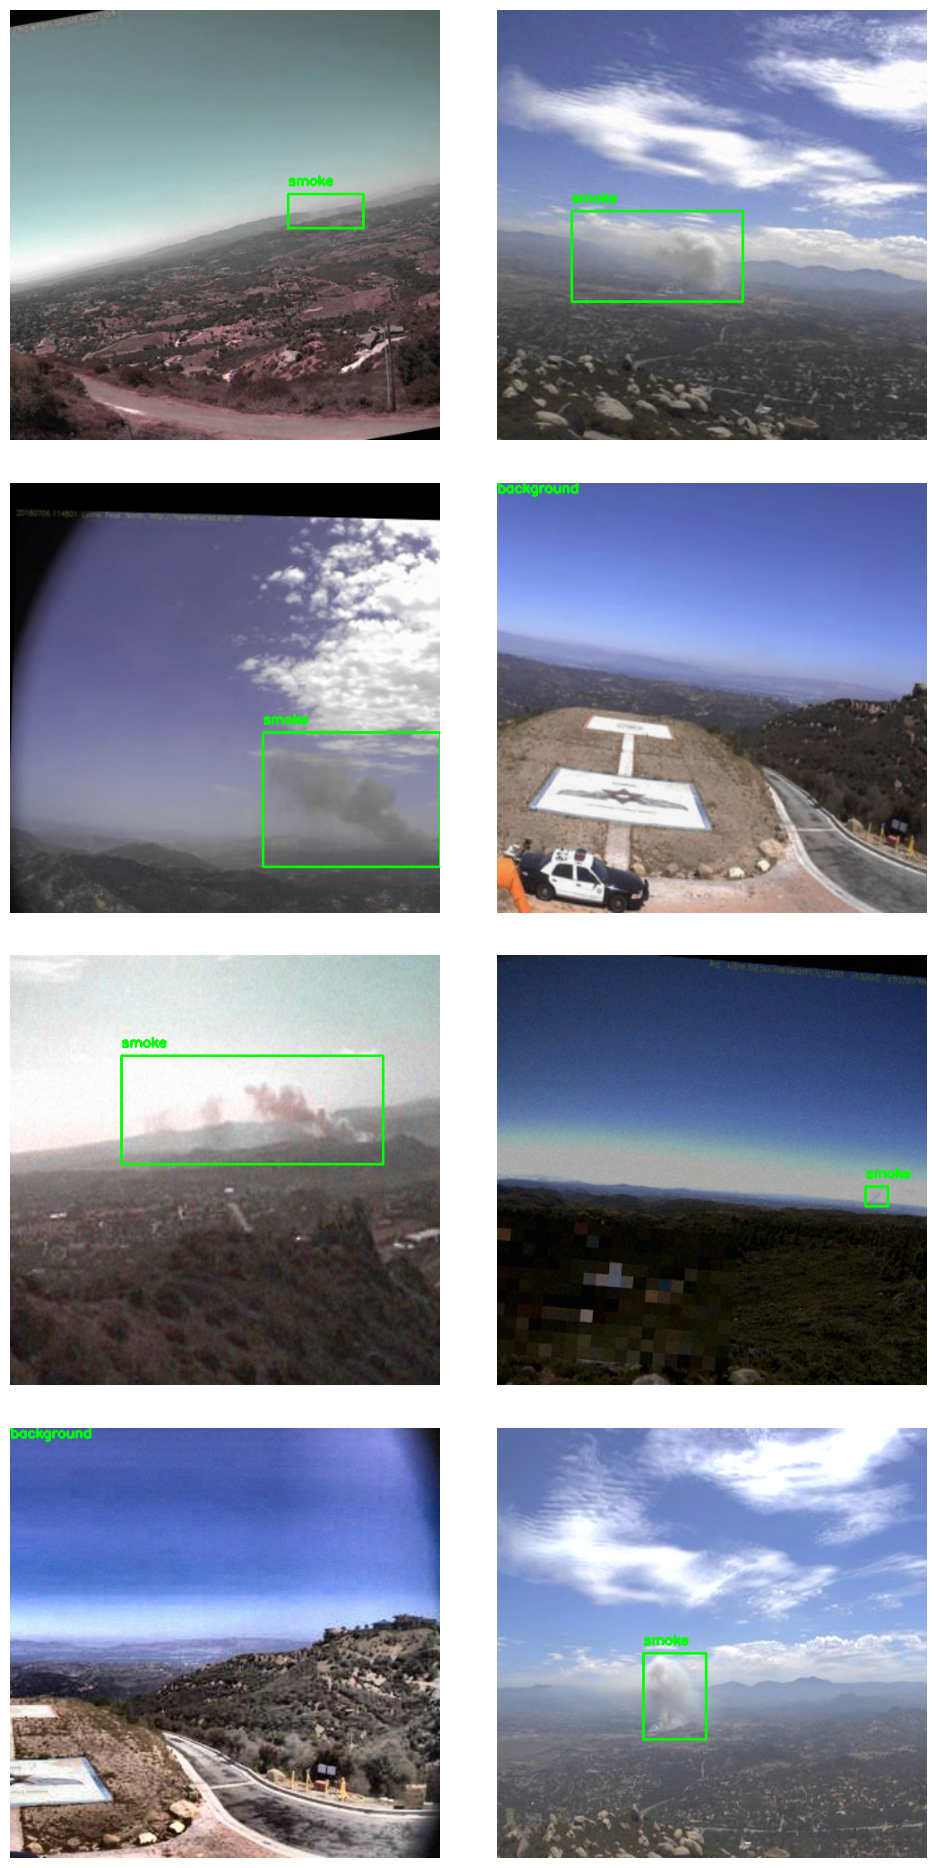

In [12]:
fig,axes=plt.subplots(4,2,figsize=(12,24))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()

idxs=np.random.choice(range(len(train_ds)),8)
for i,idx in enumerate(idxs):
    img,target=train_ds[idx]
    output_img=show_bbox(img,target)
    ax[i].imshow(output_img)
    ax[i].axis("off")

<h2 style="text-align: left; font-family: Arial; font-size: 25px; font-color: black;font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color:#8a2be2; background-color: #ffffff;">🧮🎆9.Data Loader</h2>
<h2 style="text-align: left; font-family: Arial; font-size: 20px; font-color: black;font-style: normal; text-decoration: None; text-transform: none; letter-spacing: 1px; color:#000000; background-color: #ffffff;">
these data loaders prepare the datasets for training and validation by batching the data, shuffling (for training), and parallelizing data loading across multiple CPU cores. Additionally, they handle custom collation of samples and ensure efficient data transfer to GPU if available.</h2>

In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [14]:
train_dl=DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=os.cpu_count(),
                    collate_fn=collate_fn,
                    pin_memory=True if device=="cuda" else False)
val_dl=DataLoader(val_ds,batch_size=batch_size,shuffle=False,num_workers=os.cpu_count(),
                  collate_fn=collate_fn,
                  pin_memory=True if device=="cuda" else False)

<h2 style="text-align: left; font-family: Arial; font-size: 25px; font-color: black;font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color:#8a2be2; background-color: #ffffff;">🛠️⚙️8.Building the Model</h2>

In [15]:
model=ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)

in_channels=det_utils.retrieve_out_channels(model.backbone,(480,480))
num_anchors=model.anchor_generator.num_anchors_per_location()
model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                   num_classes=num_classes)

model.to(device)

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:00<00:00, 154MB/s]  


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

<h2 style="text-align: left; font-family: Arial; font-size: 25px; font-color: black;font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color:#8a2be2; background-color: #ffffff;">✳️9.sets up the optimizer and learning rate scheduler for training the model. </h2>

<h2 style="text-align: left; font-family: Arial; font-size: 20px; font-color: black;font-style: normal; text-decoration: None; text-transform: none; letter-spacing: 1px; color:#000000; background-color: #ffffff;">
1.Freezing Backbone Parameters<br/>
2.Selecting Trainable Parameters<br/>
3.Optimizer Initialization<br/></h2>

In [16]:
for params in model.backbone.features.parameters():
    params.requires_grad=False
    
parameters=[params for params in model.parameters() if params.requires_grad]

optimizer=optim.Adam(parameters,lr=learning_rate)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, 
                                                  patience=7, threshold=0.0001)

<h2 style="text-align: left; font-family: Arial; font-size: 25px; font-color: black;font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color:#8a2be2; background-color: #ffffff;">✳️10.Training</h2>

In [17]:
def get_lr(optimizer):
    for params in optimizer.param_groups:
        return params["lr"]

In [18]:
def calculate_accuracy(predictions, targets):
    correct = 0
    total = 0
    for pred, target in zip(predictions, targets):
        pred_labels = pred['labels'].cpu().numpy()
        target_labels = target['labels'].cpu().numpy()
        correct += (pred_labels == target_labels).sum()
        total += len(target_labels)
    return correct / total

In [19]:
loss_history = {
    "training_loss": [],
    "validation_loss": [],
    "training_accuracy": [],
    "validation_accuracy": []
}


train_len=len(train_dl.dataset)
val_len=len(val_dl.dataset)

best_validation_loss=np.inf
best_weights=copy.deepcopy(model.state_dict())

for epoch in range(epochs):
    
    training_loss=0.0
    validation_loss=0.0
    
    current_lr=get_lr(optimizer)
    
    #During training, the model expects both the input tensors, as well as a targets 
    model.train()
    for imgs,targets in train_dl:
        imgs=[img.to(device) for img in imgs]
        targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
        
        loss_dict=model(imgs,targets)
        
        losses=sum(loss for loss in loss_dict.values())
        training_loss+=losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        
    with torch.no_grad():
        for imgs,targets in val_dl:
            imgs=[img.to(device) for img in imgs]
            targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
            
            loss_dict=model(imgs,targets)
            losses=sum(loss for loss in loss_dict.values())
            validation_loss+=losses.item()
        
            
    lr_scheduler.step(validation_loss)
    if current_lr!=get_lr(optimizer):
        print("Loading best Model weights")
        model.load_state_dict(best_weights)
    
    if validation_loss<best_validation_loss:
        best_validation_loss=validation_loss
        best_weights=copy.deepcopy(model.state_dict())
        print("Updating Best Model weights")
        
    
    loss_history["training_loss"].append(training_loss/train_len)
    loss_history["validation_loss"].append(validation_loss/val_len)
            
    print(f"\n{epoch+1}/{epochs}")
    print(f"Training Loss: {training_loss/train_len}")
    print(f"Validation_loss: {validation_loss/val_len}")
    print("\n"+"*"*50)

torch.save(best_weights,model_weights_file)

Updating Best Model weights

1/40
Training Loss: 2.260279842839835
Validation_loss: 1.4293872515360515

**************************************************
Updating Best Model weights

2/40
Training Loss: 2.083800705857932
Validation_loss: 1.348636786142985

**************************************************
Updating Best Model weights

3/40
Training Loss: 2.0296030364478357
Validation_loss: 1.2941220859149556

**************************************************
Updating Best Model weights

4/40
Training Loss: 1.8059797591675584
Validation_loss: 1.236840819453334

**************************************************
Updating Best Model weights

5/40
Training Loss: 1.9486710393009856
Validation_loss: 1.16976632728233

**************************************************
Updating Best Model weights

6/40
Training Loss: 1.8875604650844782
Validation_loss: 1.1126325989628698

**************************************************
Updating Best Model weights

7/40
Training Loss: 1.681478365541647
Val

<h2 style="text-align: left; font-family: Arial; font-size: 25px; font-color: black;font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color:#8a2be2; background-color: #ffffff;">📈11.Loss Visualization. </h2>

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Text(0.5, 1.0, 'Training Validation Datasets Losses Plot')

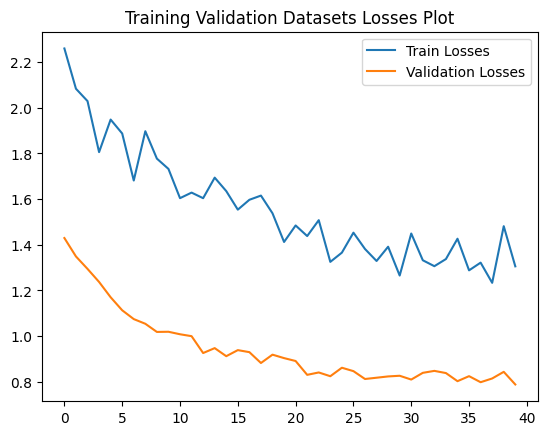

In [20]:
sns.lineplot(x=range(epochs),y=loss_history["training_loss"],label="Train Losses");
sns.lineplot(x=range(epochs),y=loss_history["validation_loss"],label="Validation Losses");
plt.title("Training Validation Datasets Losses Plot")
# Add values as text to the plot
# for i in range(epochs):
#     plt.text(i, loss_history["training_loss"][i], f'{loss_history["training_loss"][i]:.2f}', color='blue', ha="center")
#     plt.text(i, loss_history["validation_loss"][i], f'{loss_history["validation_loss"][i]:.2f}', color='orange', ha="center")

<h2 style="text-align: left; font-family: Arial; font-size: 25px; font-color: black;font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color:#8a2be2; background-color: #ffffff;">💾11.Saving a model. </h2>

In [21]:
model_weights_pth="/kaggle/working/model.pth"
model=ssd300_vgg16()

in_channels=det_utils.retrieve_out_channels(model.backbone,(480,480))
num_anchors=model.anchor_generator.num_anchors_per_location()
model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                   num_classes=num_classes)

model.load_state_dict(torch.load(model_weights_pth,map_location=device))
model.to(device)

Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth
100%|██████████| 528M/528M [00:03<00:00, 162MB/s]  


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

<h2 style="text-align: left; font-family: Arial; font-size: 25px; font-color: black;font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color:#8a2be2; background-color: #ffffff;">🧬12.Preprocessing a image. </h2>

In [22]:
def preprocess_bbox(prediction):
    
    """Non-max suppression is the final step of these object detection algorithms and is 
       used to select the most appropriate bounding box for the object.
       The NMS takes two things into account
        -The objectiveness score is given by the model
        -The overlap or IOU of the bounding boxes"""
    
    processed_bbox={}
    
    boxes=prediction["boxes"][prediction["scores"]>=threshold]
    scores=prediction["scores"][prediction["scores"]>=threshold]
    labels=prediction["labels"][prediction["scores"]>=threshold]
    nms=torchvision.ops.nms(boxes,scores,iou_threshold=iou_threshold)
            
    processed_bbox["boxes"]=boxes[nms]
    processed_bbox["scores"]=scores[nms]
    processed_bbox["labels"]=labels[nms]
    
    return processed_bbox

<h2 style="text-align: left; font-family: Arial; font-size: 25px; font-color: black;font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color:#8a2be2; background-color: #ffffff;">📈13.Metrices. </h2>

In [23]:
metric=MeanAveragePrecision(box_format='xyxy',class_metrics=True)
metric.to(device)

model.eval()
with torch.no_grad():
    for imgs,targets in val_dl:
        imgs=[img.to(device) for img in imgs]
        targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
        predictions=model(imgs)
        
        results=[]
        for prediction in predictions:
            results.append(preprocess_bbox(prediction))
        
        metric.update(results,targets)
        
results=metric.compute()

In [24]:
mean_ap=results["map"].item()
mean_ap_50=results["map_50"].item()
mean_ap_75=results["map_75"].item()

print(f"Mean Average Precision[0.5:0.95:0.05] : {mean_ap:.4f}")
print(f"Mean Average Precision @ 0.5          : {mean_ap_50:.4f}")
print(f"Mean Average Precision @ 0.75         : {mean_ap_75:.4f}")

Mean Average Precision[0.5:0.95:0.05] : 0.3145
Mean Average Precision @ 0.5          : 0.6965
Mean Average Precision @ 0.75         : 0.2310


<h2 style="text-align: left; font-family: Arial; font-size: 25px; font-color: black;font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color:#8a2be2; background-color: #ffffff;">🗜️14.Predicting the image. </h2>

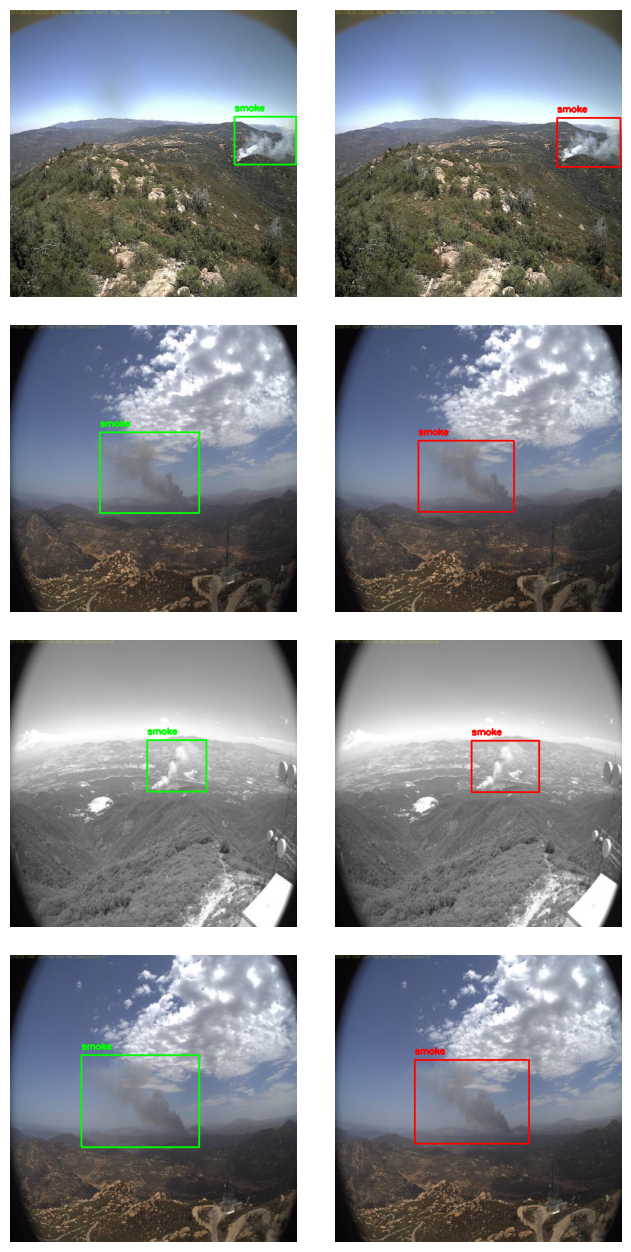

In [25]:
"""During inference, the model requires only the input tensors, and returns the 
   post-processed predictions as a List[Dict[Tensor]], one for each input image. The fields
   of the Dict are as follows:
   - boxes (FloatTensor[N, 4]): the predicted boxes in [x0, y0, x1, y1] format
   - labels (Int64Tensor[N]): the predicted labels for each image
   - scores (Tensor[N]): the scores or each prediction"""

fig,axes=plt.subplots(4,2,figsize=(8,16))
plt.subplots_adjust(wspace=0.1,hspace=0.1)

imgs,targets=next(iter(val_dl))
model.eval()
with torch.no_grad():
    output=model([img.to(device) for img in imgs])

for i,idx in enumerate(range(len(imgs))):
    img=imgs[idx]
    prediction=output[idx]
    #real bounding boxes
    output_img=show_bbox(img,targets[idx],color=(0,255,0));
    axes[i,0].imshow(output_img);
    axes[i,0].axis("off");
    
    #predicted bounding box
    predict=preprocess_bbox(prediction)
    output_img=show_bbox(img,predict,color=(255,0,0));
    axes[i,1].imshow(output_img);
    axes[i,1].axis("off");
    
plt.savefig("4.png")

<h2 style="text-align: left; font-family: Arial; font-size: 25px; font-color: black;font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color:#8a2be2; background-color: #ffffff;">🗜️15.Testing the image. </h2>

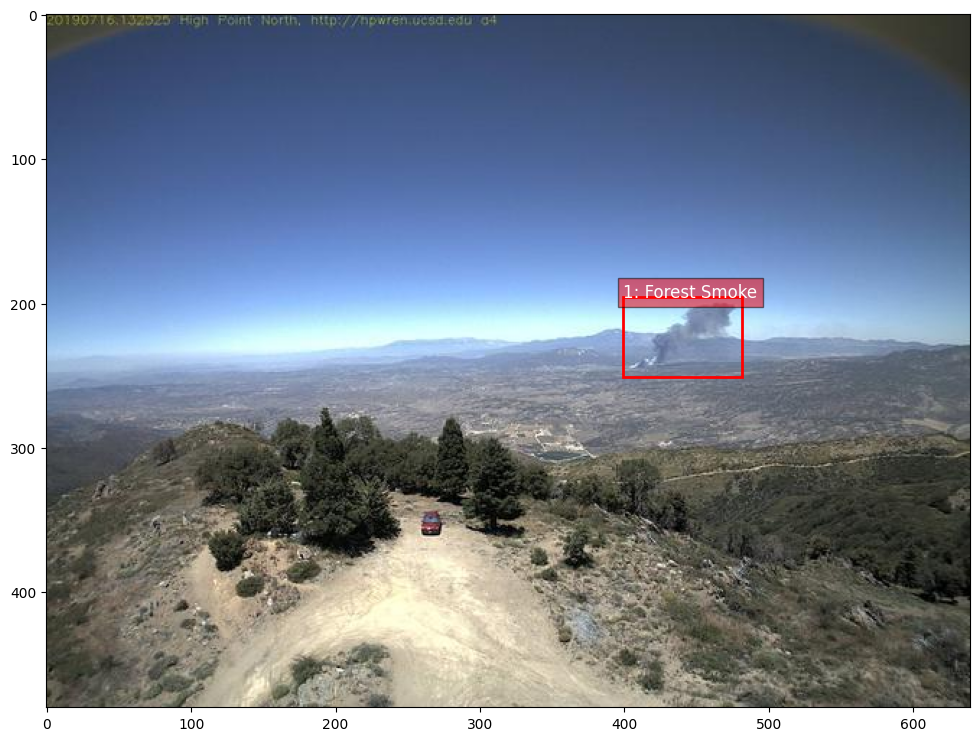

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from torchvision.transforms.functional import to_tensor
from PIL import Image

# Load the single image
image_path = "/kaggle/input/smoke-pascal-voc/images/ck0kcubsi4r530863gt6or3em_jpeg.rf.85b35b9cbcbe849c2b67784936eed59f.jpg"
img = Image.open(image_path).convert("RGB")

# Preprocess the image
img_tensor = to_tensor(img)
img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension if missing

# Make predictions
model.eval()
with torch.no_grad():
    # Move the input image tensor to the same device as the model
    img_tensor = img_tensor.to(device)
    
    # Get the model output
    output = model(img_tensor)
    
# Move the predicted bounding box coordinates to CPU
prediction = output[0]  # Since we have only one image, take the first prediction

# Extract the boxes, scores, and labels
boxes = output[0]['boxes'].cpu().numpy()
scores = output[0]['scores'].cpu().numpy()
labels = output[0]['labels'].cpu().numpy()

# Set confidence threshold
confidence_threshold = 0.5

# Filter out low-confidence detections
high_conf_indices = scores >= confidence_threshold
boxes = boxes[high_conf_indices]
scores = scores[high_conf_indices]
labels = labels[high_conf_indices]

# Plot the image and overlay the bounding boxes
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(img)

# Add bounding boxes to the plot
for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    width = xmax - xmin
    height = ymax - ymin
    
    # Create a rectangle patch
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
    
    # Add the rectangle to the plot
    ax.add_patch(rect)
    
    # Add label and score to the bounding box
    # Add label and score to the bounding box
    if score <= 1:
        ax.text(xmin, ymin, f'{label}: Forest Smoke', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
    else:
        ax.text(xmin, ymin, f'{label}:Background', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

plt.show()


<h2 style="text-align: left; font-family: Arial; font-size: 25px; color: #8a2be2; background-color: #ffffff;">🙏 Thank You for Visiting and Reading My Code!</h2>

<p style="font-family: Arial; font-size: 18px; color: #000000; background-color: #ffffff;">
Thank you for taking the time to visit my Kaggle notebook and read through my code. I hope you found it helpful and informative. Your feedback and suggestions are always welcome as they help me improve and grow.
</p>

<p style="font-family: Arial; font-size: 18px; color: #000000; background-color: #ffffff;">
If you have any questions or need further clarification, please feel free to reach out. Happy coding!
</p>

<p style="font-family: Arial; font-size: 18px; color: #000000; background-color: #ffffff;">
Best regards,<br>
[Pavankumar Elango]
</p>
